### Dependencies

In [34]:
import geopandas as gpd

import pickle
import numpy as np

from matplotlib import pyplot as plt
from kalmanutils import interpolate_geometries, align_vertices

from shapely.geometry import MultiPolygon
import contextily as cx

def calculate_rms(geom1, geom2):
    xy1, xy2 = interpolate_geometries([geom1, geom2], vertex_count=100)
    xy1, xy2 = align_vertices([xy1, xy2])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)

# geom = gpd.read_file('/home/jovyan/data/20230517/Run_00013/out_Perimeters.shp')['geometry'][0]
# geom2 = 

In [193]:
import pickle
import numpy as np

from matplotlib import pyplot as plt
from kalmanutils import interpolate_geometries, align_vertices

from shapely.geometry import MultiPolygon
import contextily as cx

def calculate_rms(geom1, geom2):
    xy1, xy2 = interpolate_geometries([geom1, geom2], vertex_count=100)
    xy1, xy2 = align_vertices([xy1, xy2])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
def plot_matrix(X, ax, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)

def plot_matrix_ensemble(X, ax, plot_alix = None, **kwargs):
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = 0.1, color=kwargs['color'], edgecolors=(0,0,0,0))

with open('/home/jovyan/data/output_Maria_2.pkl', 'rb') as f:
    data = pickle.load(f)
    

In [194]:
def plot_ensemble_compare(data, plotix, ax, plot_alix=None):
    wdmaria = [37, 48, 48, 44, 16]
    wsmaria = [11, 18, 18, 25, 17]
    objectidlst = [21231, 21232, 21234, 21235, 21236]
    wd = wdmaria[plotix]
    
    plot_matrix_ensemble(data['calculations'][plotix]['Y'], ax=ax, plot_alix=plot_alix, label='observation', lw=0.1, color=(0,0,0,0.05))
    plot_matrix_ensemble(data['calculations'][plotix]['Xt'][:-2,:], ax=ax, plot_alix=plot_alix, label='simulation', lw=0.1, color=(1,0,0,0.05))
    plot_matrix_ensemble(data['calculations'][plotix]['X'][:-2,:], ax=ax, plot_alix=plot_alix, label='updated', lw=0.1, color=(0,0,1,0.05))
    
    gdfignition = data['gdfignition']
    igniteidx = data['calculations'][plotix]['igniteidx']
    

    gdfignition.loc[[igniteidx], 'geometry'].plot(ax=ax, color=(0,0,0,0), edgecolor=(0,0,0,1), ls='--')
    
    x0 = -2.090e6
    y0 = 1.507e6
    draw_wind_direction(ax, wd, arrlength=1e3, x0=x0, y0=y0, width=150)
    
    ax.text(x0, y0-1e3+200, f'ws={wsmaria[plotix]}')
    ax.text(x0, y0-1e3+600, f'wd={wdmaria[plotix]}')
    
    ax.set_xlim((-2092286.5426307796, -2080173.4025845625))
    ax.set_ylim((1500598.4375278142, 1508168.8614191345))
    
def plot_mean_compare(data, plotix, ax):
    wdmaria = [37, 48, 48, 44, 16]
    wsmaria = [11, 18, 18, 25, 17]
    objectidlst = [21231, 21232, 21234, 21235, 21236]
    wd = wdmaria[plotix]
    
    plot_matrix(data['calculations'][plotix]['Y'], ax=ax, label='observation', show_stdev=True, color=(0,0,0))
    plot_matrix(data['calculations'][plotix]['Xt'][:-2,:], ax=ax, label='sim', show_stdev=True, color=(1,0,0))
    plot_matrix(data['calculations'][plotix]['X'][:-2,:], ax=ax, label='updated', show_stdev=True, color=(0,0,1))

    x0 = -2.090e6
    y0 = 1.507e6
    draw_wind_direction(ax, wd, arrlength=1e3, x0=x0, y0=y0, width=150)
    
    ax.text(x0, y0-1e3+200, f'ws={wsmaria[plotix]}')
    ax.text(x0, y0-1e3+600, f'wd={wdmaria[plotix]}')
    
    ax.set_xlim((-2092286.5426307796, -2080173.4025845625))
    ax.set_ylim((1500598.4375278142, 1508168.8614191345))
    
    
def draw_wind_direction(ax, wd, x0=0, y0=0, arrlength=0.25, width=0.04, **kwargs):
    arrdir = 270-wd

    dx = arrlength*np.cos(arrdir/180*np.pi)
    dy = arrlength*np.sin(arrdir/180*np.pi)

    ax.arrow(x0, y0, dx, dy, width=width, edgecolor=(0,0,0,0), head_width=2*width, head_length=1.5*width, **kwargs)


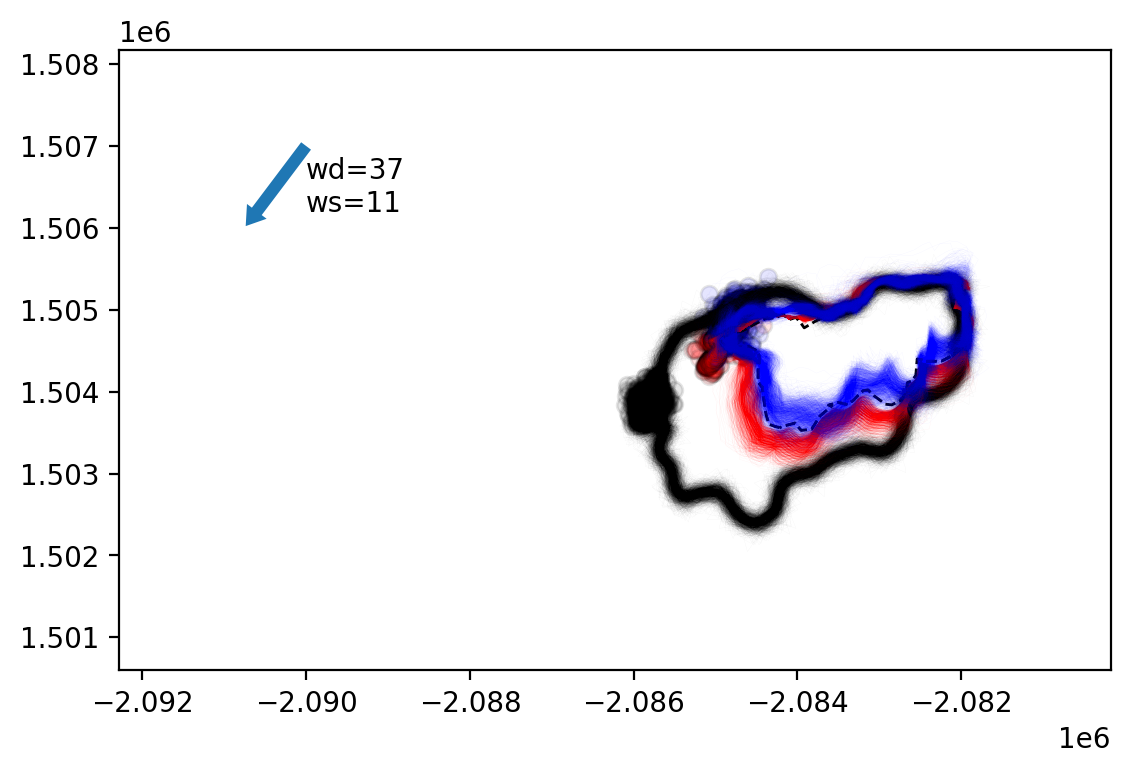

In [195]:
fig, ax = plt.subplots(1,1, dpi=200)

plot_ensemble_compare(data, 0, ax, plot_alix=0)

# cx.add_basemap(ax=ax, crs=data['gdfignition'].crs.to_string(), source=cx.providers.OpenTopoMap)

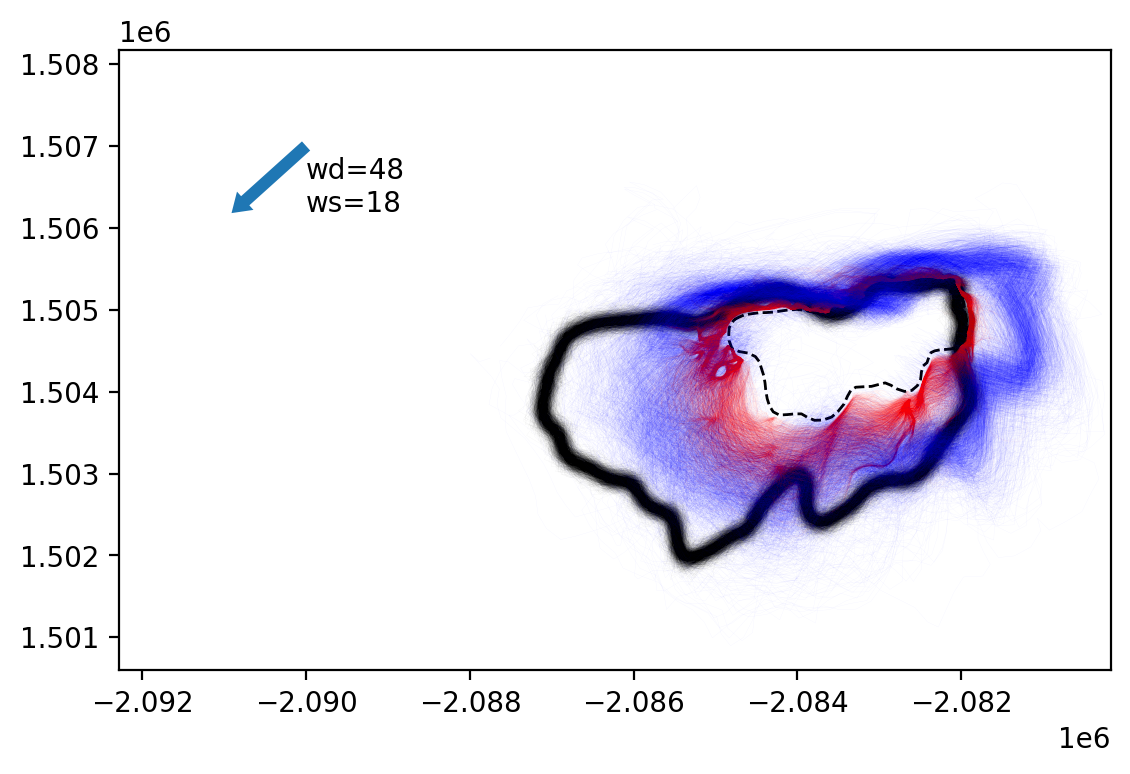

In [151]:
fig, ax = plt.subplots(1,1, dpi=200)

plot_ensemble_compare(data, 1, ax)

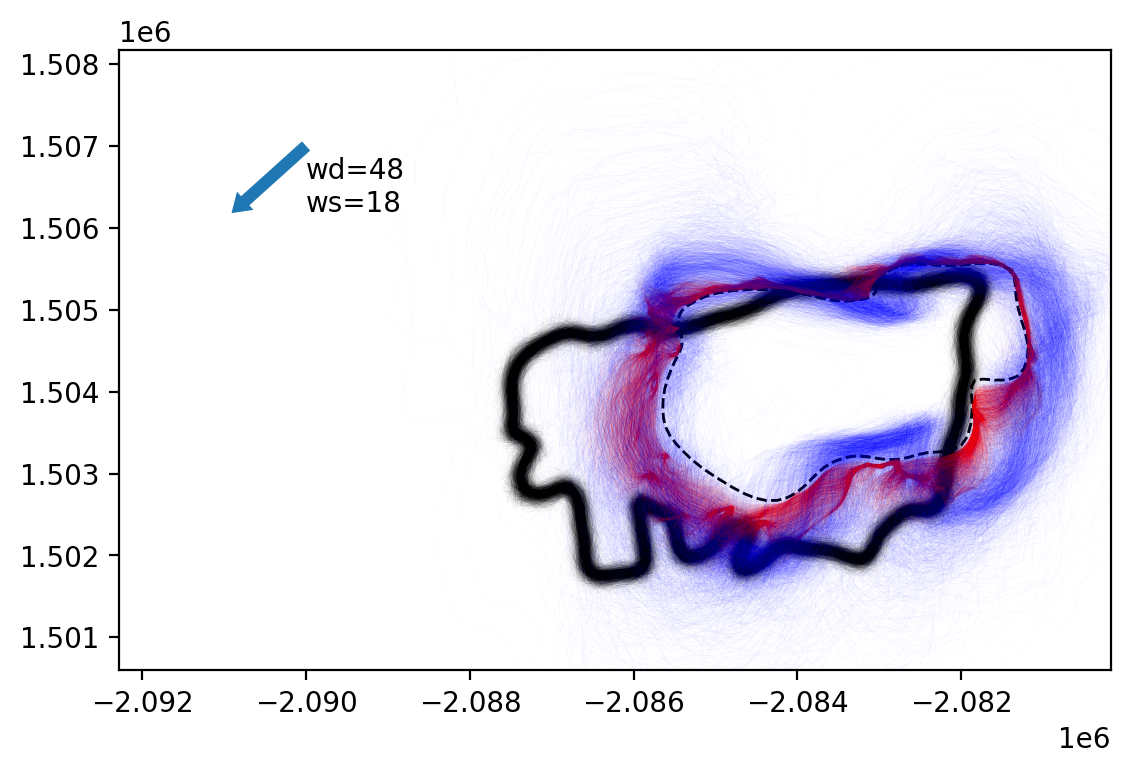

In [152]:
fig, ax = plt.subplots(1,1, dpi=200)

plot_ensemble_compare(data, 2, ax)

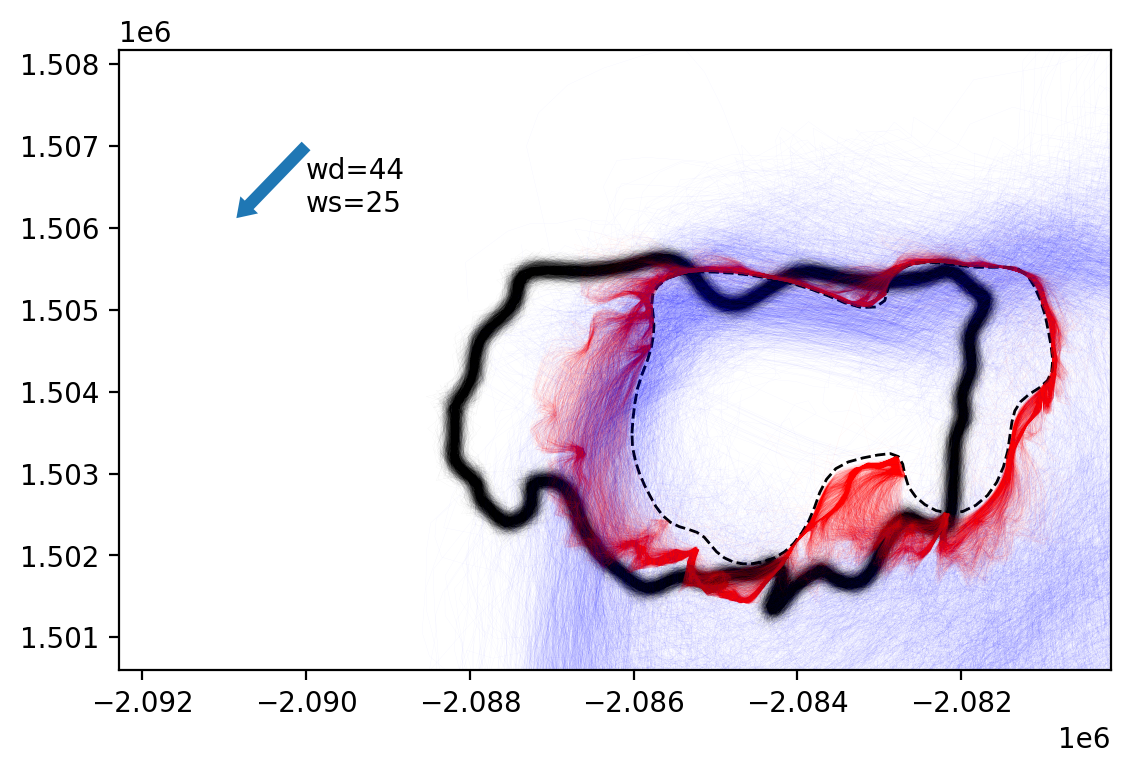

In [153]:
fig, ax = plt.subplots(1,1, dpi=200)

plot_ensemble_compare(data, 3, ax)

In [167]:
xlim = (-2087783.9037608402, -2079125.1554676027)
ylim = (1500544.4032270547, 1506759.0368470687)

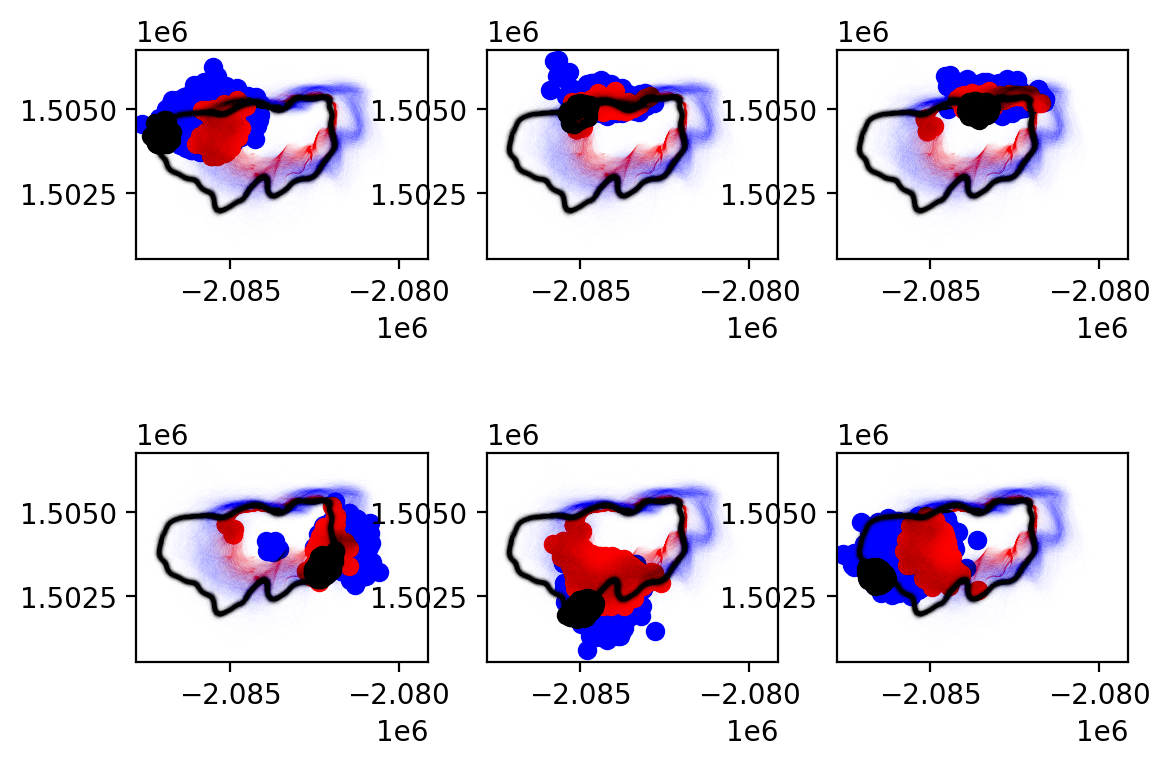

In [215]:
plotix = 1

fig, axes2d = plt.subplots(2,3, dpi=200)
axes = axes2d.flatten()

for ax, plot_alix in zip(axes, [0,15,25,50,75,90]):
    Xt = data['calculations'][plotix]['Xt'][:-2,:]
    Y = data['calculations'][plotix]['Y']
    X = data['calculations'][plotix]['X'][:-2,:]
    
    plot_matrix_ensemble(X, ax=ax, lw=0.1, color=(0,0,1,0.01))
    ax.scatter(X[2*plot_alix, :], X[2*plot_alix+1, :], color=(0,0,1,1))

    plot_matrix_ensemble(Xt, ax=ax, lw=0.1, color=(1,0,0,0.01))
    ax.scatter(Xt[2*plot_alix, :], Xt[2*plot_alix+1, :], color=(1,0,0,1))    
    
    plot_matrix_ensemble(Y, ax=ax, lw=0.1, color=(0,0,0,0.01))
    ax.scatter(Y[2*plot_alix, :], Y[2*plot_alix+1, :], color=(0,0,0,1))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    

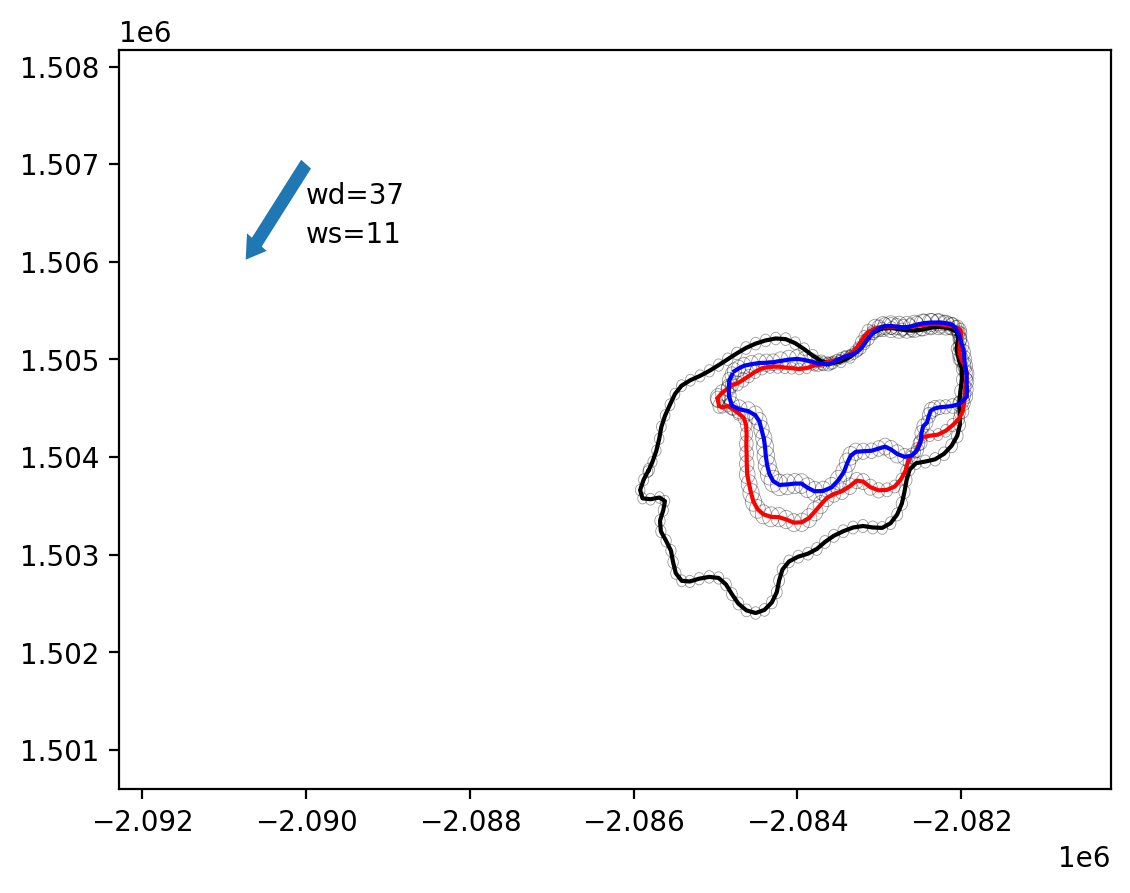

In [150]:
fig, ax = plt.subplots(1,1, dpi=200)
plotix = 0

plot_mean_compare(data, plotix, ax)


In [ ]:
data['gdfignition'].loc[data['calculations'][0]['igniteidx']]['geometry']

In [ ]:
data

In [ ]:
data['gdfignition']

In [ ]:
fig, ax = plt.subplots(1,1, dpi=200)

plot_geometry(gdfmaria_aircraft.iloc[0]['geometry'], ax=ax)

for gdfix, gdfrow in gdfreference.iloc[::2].iterrows():
    plot_geometry(geom=gdfrow['geometry'], ax=ax, color=(1,0,0), ls='--', lw=1)

plot_geometry(gdfmaria_aircraft.iloc[1]['geometry'], ax=ax, color='tab:blue')    

ax.set_xlim((-2089657.8, -2080928.2))
ax.set_ylim((1501761.0, 1506249.0))  

    
cx.add_basemap(ax=ax, crs=gdfreference.crs.to_string(), source=cx.providers.OpenTopoMap)



In [ ]:
gdfmaria_aircraft.iloc[1]